In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from blacklitterman import BlackLitterman ,Optimization,Optimization_MVO

3.7.9


In [2]:
## Paremeters 
start_date = datetime.date(2020,1,2) ##回測2020年
period = 5 ##幾天換一次權重
# stock_list = ['2303', '2885', '2603', '2884', '2883']
stock_list = ['2330','2885','2603','2303','2881']

In [3]:
df = pd.read_csv('./preprocessing/log_return.csv',parse_dates = ['date'],index_col = 'date')
## 回測2020資料
df_backtest = df[df.index.year == 2020]
index = np.array([i for i in range(len(df_backtest.index))])
change_weight_days = df_backtest.index[index[index%period == 0]]  ##要更換權重的天數

### BlackLitterman with Constant View

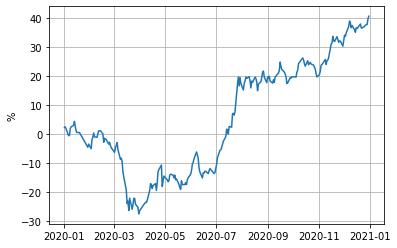

In [4]:
ret_port = [0]
cw_ret = [0]
weight_port = {}
c_weight= {}
for i,date in enumerate(change_weight_days):
    BL = BlackLitterman(start_day = date,stock_list = stock_list)
    df_test = df_backtest[BL.stock_list]
    try:
        df_period = df_test.loc[change_weight_days[i]:change_weight_days[i+1],:]
        df_period = df_period.iloc[0:-1,:]
    except:
        df_period = df_test.loc[date:,:]
    df_period = np.array(df_period)
    ret,var = BL.posterior_dist()
    OPT = Optimization(ret,var,stock_list)
    weight = OPT.best_sharpe(print_process =False)
    cw_weight = BL.utility_weight()
    cw_weight = np.squeeze(np.exp(cw_weight)/np.sum(np.exp(cw_weight)),axis = 1)
    returns = np.dot(df_period,weight)
    cw_rets = np.dot(df_period,cw_weight)
    ##紀錄weight
    weight_port[date] = weight
    c_weight[date] = cw_weight
    for r in returns:
        ret_port.append(ret_port[-1]+r)
    for r in cw_rets:
        cw_ret.append(cw_ret[-1]+r)
plt.plot(df_backtest.index,ret_port[1:])
plt.ylabel('%')
plt.grid(True)

In [5]:
weight_port

{Timestamp('2020-01-02 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-01-09 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-01-16 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-02-03 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-02-10 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-02-17 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-02-24 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-03-03 00:00:00'): array([0.5812, 0.2055, 0.    , 0.0071, 0.2063]),
 Timestamp('2020-03-10 00:00:00'): array([0.3296, 0.2827, 0.0631, 0.0727, 0.252 ]),
 Timestamp('2020-03-17 00:00:00'): array([0., 0., 1., 0., 0.]),
 Timestamp('2020-03-24 00:00:00'): array([0.    , 0.    , 0.5788, 0.4212, 0.    ]),
 Timestamp('2020-03-31 00:00:00'): array([0., 0., 0., 1., 0.]),
 Timestamp('2020-04-09 00:00:00'): array([0., 0., 0., 1., 0.]),
 Timestamp('2020-04-16 00:00:00'): array([0., 0., 0., 1., 0.]),
 Timestamp('2020-04-23 00:00:00'): array([0.

In [6]:
c_weight

{Timestamp('2020-01-02 00:00:00'): array([0.30219694, 0.17577915, 0.17595767, 0.17902506, 0.16704118]),
 Timestamp('2020-01-09 00:00:00'): array([0.30538657, 0.17268315, 0.17601464, 0.17742268, 0.16849296]),
 Timestamp('2020-01-16 00:00:00'): array([0.30502932, 0.17185276, 0.17664656, 0.17726593, 0.16920542]),
 Timestamp('2020-02-03 00:00:00'): array([0.31210038, 0.1713356 , 0.17017061, 0.17341171, 0.1729817 ]),
 Timestamp('2020-02-10 00:00:00'): array([0.31649226, 0.17341027, 0.16759221, 0.17466464, 0.16784061]),
 Timestamp('2020-02-17 00:00:00'): array([0.31645221, 0.1759237 , 0.16761775, 0.17357339, 0.16643295]),
 Timestamp('2020-02-24 00:00:00'): array([0.31390408, 0.17702508, 0.16862548, 0.17189793, 0.16854743]),
 Timestamp('2020-03-03 00:00:00'): array([0.29435895, 0.19446188, 0.14759912, 0.1585211 , 0.20505895]),
 Timestamp('2020-03-10 00:00:00'): array([0.24688524, 0.23297273, 0.11488576, 0.13965659, 0.26559968]),
 Timestamp('2020-03-17 00:00:00'): array([0.33382228, 0.16572086

###  Markowitz Using 50 days Lookback

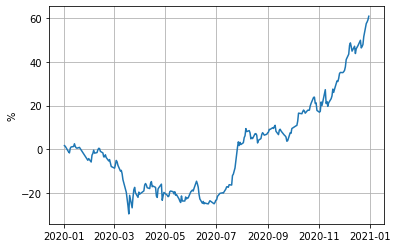

In [7]:
mvo_ret_port = [0]
mvo_weight_port = {}
for i,date in enumerate(change_weight_days):
    BL = BlackLitterman(start_day = date, stock_list = stock_list)
    df_test = df_backtest[BL.stock_list]
    try:
        df_period = df_test.loc[change_weight_days[i]:change_weight_days[i+1],:]
        df_period = df_period.iloc[0:-1,:]
    except:
        df_period = df_test.loc[date:,:]
    df_period = np.array(df_period)
    ret = BL.get_return().mean()
    var = BL.get_return().cov()
    OPT_MVO = Optimization_MVO(ret,var,stock_list)
    weight = OPT_MVO.best_sharpe(print_process =False)
    returns = np.dot(df_period,weight)
    ##紀錄weight
    mvo_weight_port[date] = weight
    for r in returns:
        mvo_ret_port.append(mvo_ret_port[-1]+r)
plt.plot(df_backtest.index,mvo_ret_port[1:])
plt.ylabel('%')
plt.grid(True)

In [8]:
OPT_MVO.stock_list

['2330', '2885', '2603', '2303', '2881']

In [9]:
mvo_weight_port

{Timestamp('2020-01-02 00:00:00'): array([0.6421, 0.0951, 0.    , 0.2628, 0.    ]),
 Timestamp('2020-01-09 00:00:00'): array([0.6178, 0.0802, 0.    , 0.302 , 0.    ]),
 Timestamp('2020-01-16 00:00:00'): array([0.3604, 0.3993, 0.    , 0.2404, 0.    ]),
 Timestamp('2020-02-03 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-02-10 00:00:00'): array([0.1851, 0.1927, 0.    , 0.6222, 0.    ]),
 Timestamp('2020-02-17 00:00:00'): array([0.1985, 0.    , 0.    , 0.8015, 0.    ]),
 Timestamp('2020-02-24 00:00:00'): array([0.3463, 0.    , 0.    , 0.6537, 0.    ]),
 Timestamp('2020-03-03 00:00:00'): array([0., 0., 0., 1., 0.]),
 Timestamp('2020-03-10 00:00:00'): array([0.8704, 0.    , 0.    , 0.1296, 0.    ]),
 Timestamp('2020-03-17 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-03-24 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-03-31 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-04-09 00:00:00'): array([1., 0., 0., 0., 0.]),
 Timestamp('2020-04-16 00:00

### 平均權重

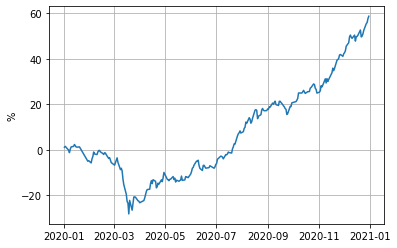

In [10]:
even_ret = [0]
weight = np.array([0.2,0.2,0.2,0.2,0.2])
for i,date in enumerate(change_weight_days):
    BL = BlackLitterman(start_day = date,stock_list = stock_list)
    df_test = df_backtest[BL.stock_list]
    try:
        df_period = df_test.loc[change_weight_days[i]:change_weight_days[i+1],:]
        df_period = df_period.iloc[0:-1,:]
    except:
        df_period = df_test.loc[date:,:]
    df_period = np.array(df_period)
    returns = np.dot(df_period,weight)

    for r in returns:
        even_ret.append(even_ret[-1]+r)
plt.plot(df_backtest.index,even_ret[1:])
plt.ylabel('%')
plt.grid(True)

### BlackLitterman with LSTM-Based View

In [11]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("--tf_version :" ,tf.__version__)
print(tf.config.list_physical_devices('GPU'))

--tf_version : 2.1.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [12]:
seq_len = 30
feature = 10

input1 = keras.Input(shape =(seq_len,feature),name = stock_list[0])
input2 = keras.Input(shape =(seq_len,feature),name = stock_list[1])
input3 = keras.Input(shape =(seq_len,feature),name = stock_list[2])
input4 = keras.Input(shape =(seq_len,feature),name = stock_list[3])
input5 = keras.Input(shape =(seq_len,feature),name = stock_list[4])

out1 = layers.LSTM(32,return_sequences=True)(input1)
out2 = layers.LSTM(32,return_sequences=True)(input2)
out3 = layers.LSTM(32,return_sequences=True)(input3)
out4 = layers.LSTM(32,return_sequences=True)(input4)
out5 = layers.LSTM(32,return_sequences=True)(input5)

out1 = layers.LSTM(64)(out1)
out2 = layers.LSTM(64)(out2)
out3 = layers.LSTM(64)(out3)
out4 = layers.LSTM(64)(out4)
out5 = layers.LSTM(64)(out5)

concat = layers.concatenate([out1,out2,out3,out4,out5])
d1 = layers.Dense(64)(concat)
d2 = layers.Dense(5,activation = 'relu', name="result")(d1)


model = keras.Model(
    inputs=[input1,input2,input3,input4,input5],
    outputs=d2,
)

In [13]:
# model.load_weights('./stock_price_prediction/weight/best_weight.h5')
model.load_weights('./stock_price_prediction/weight/best_weight.h5')

In [14]:
def normalize(train):
    train_norm = train.apply(lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)))
    return train_norm
def get_price_data():
    data = {}
    for name in stock_list:
        df = pd.read_csv('./stock_price_prediction/data/'+'final_'+name+'.csv',parse_dates = ['date'],index_col = 'date')
        df = df.loc['2019-01-02':'2020-12-31']
        data[name] = df
    return data,df.index

In [15]:
def get_Q(date):
    ##look back 30 days
    data,date_index = get_price_data()
    num = date_index.get_loc('%d-%d-%d'%(date.year,date.month,date.day))
    test = {};scale = [];last_close = []
    for name in stock_list:
        df = data[name].iloc[num-30:num,:]
        last_close.append(df['close'][-1])
        scale.append([df['close'].max(),df['close'].min()])
        df = normalize(df)
        test[name] = np.array(df)[np.newaxis,:]
    y = model.predict([test[stock_list[0]],test[stock_list[1]],\
                       test[stock_list[2]],test[stock_list[3]],test[stock_list[4]]])

    y = np.squeeze(y,axis = 0)
    for i,elt in enumerate(y):
        diff = scale[i][0]-scale[i][1]
        elt = elt*diff + scale[i][1]
        y[i] = elt

    y = np.log(y/np.array(last_close))
    return np.expand_dims(y,axis = 1)

In [16]:
get_Q(datetime.date(2020,1,2))

array([[ 0.01118866],
       [ 0.00304863],
       [-0.0002074 ],
       [ 0.00329935],
       [ 0.00472652]])

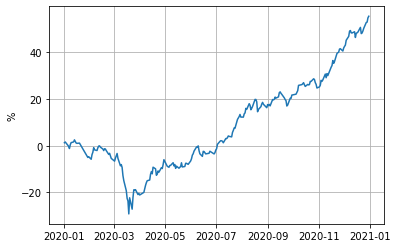

In [17]:
lstm_ret_port = [0]
lstm_weight_port = {}
Q_list = {}
for i,date in enumerate(change_weight_days):
    Q = get_Q(date)
    Q_list[date] = Q.tolist()
    BL = BlackLitterman(TAU = 0.025,start_day = date,period = 1000,stock_list = stock_list,Q = Q)
    df_test = df_backtest[BL.stock_list]
    try:
        df_period = df_test.loc[change_weight_days[i]:change_weight_days[i+1],:]
        df_period = df_period.iloc[0:-1,:]
    except:
        df_period = df_test.loc[date:,:]
    df_period = np.array(df_period)
    ret,var = BL.posterior_dist()
    ##### investors utility weight
    weight = BL.utility_weight()
    weight = np.squeeze(np.exp(weight)/np.sum(np.exp(weight)),axis = 1)
    returns = np.dot(df_period,weight)
    ##紀錄weight
    lstm_weight_port[date] = weight
    for r in returns:
        lstm_ret_port.append(lstm_ret_port[-1]+r)
plt.plot(df_backtest.index,lstm_ret_port[1:])
plt.ylabel('%')
plt.grid(True)

In [18]:
lstm_weight_port

{Timestamp('2020-01-02 00:00:00'): array([0.30727168, 0.16742382, 0.17456775, 0.17596039, 0.17477636]),
 Timestamp('2020-01-09 00:00:00'): array([0.28531209, 0.1884499 , 0.16186989, 0.17869444, 0.18567368]),
 Timestamp('2020-01-16 00:00:00'): array([0.29851005, 0.1658826 , 0.16919137, 0.19123197, 0.175184  ]),
 Timestamp('2020-02-03 00:00:00'): array([0.30440501, 0.15663751, 0.1779945 , 0.1853306 , 0.17563238]),
 Timestamp('2020-02-10 00:00:00'): array([0.32371188, 0.15056697, 0.19561052, 0.15362194, 0.17648869]),
 Timestamp('2020-02-17 00:00:00'): array([0.29208766, 0.17555786, 0.19093982, 0.18742946, 0.1539852 ]),
 Timestamp('2020-02-24 00:00:00'): array([0.32299184, 0.14261343, 0.17929741, 0.19273513, 0.16236219]),
 Timestamp('2020-03-03 00:00:00'): array([0.30610461, 0.22190484, 0.14652003, 0.17412612, 0.1513444 ]),
 Timestamp('2020-03-10 00:00:00'): array([0.28561576, 0.21937901, 0.140702  , 0.17098844, 0.18331479]),
 Timestamp('2020-03-17 00:00:00'): array([0.25205495, 0.25359416

In [19]:
pd.DataFrame.from_dict(Q_list,orient='index',columns = stock_list)

,2330,2885,2603,2303,2881
2020-01-02,[0.011188657529092975],[0.0030486260805005],[-0.0002073995240814684],[0.0032993508087882898],[0.004726516989061249]
2020-01-09,[0.007494690347238465],[0.018937004940899067],[-0.011026430231605013],[0.018316949442610503],[0.014146393768861164]
2020-01-16,[-0.016567381133918698],[-0.012469523697274072],[-0.039687462521730055],[-0.0005979817151013544],[-0.008183925655396515]
2020-02-03,[0.048006479520664155],[0.02336127985559826],[0.05469960316705439],[0.06869213157641357],[0.026735478605027688]
2020-02-10,[0.009074477016239419],[-0.00970038287867312],[0.020873975104221256],[-0.04088506057442002],[0.001277082738280691]
2020-02-17,[-0.004496776203855543],[0.00264841921402692],[0.015776819683228378],[0.012275217562757276],[-0.007069036548252387]
2020-02-24,[0.02702073723048083],[-0.003035509718033889],[0.020052742758798592],[0.041265645590284554],[0.005242920008268318]
2020-03-03,[0.05387580717915106],[0.05065419333349602],[0.022723947408503115],[0.062233620913652116],[0.022718450705307418]
2020-03-10,[0.04817188801860746],[0.053052503264208496],[0.018857796809027327],[0.0612690656069277],[0.035836594641685954]
2020-03-17,[0.11516710001385407],[0.1101587909653791],[0.1027377963817824],[0.08831737677366837],[0.09868069641172326]


In [20]:
type(Q_list)

dict

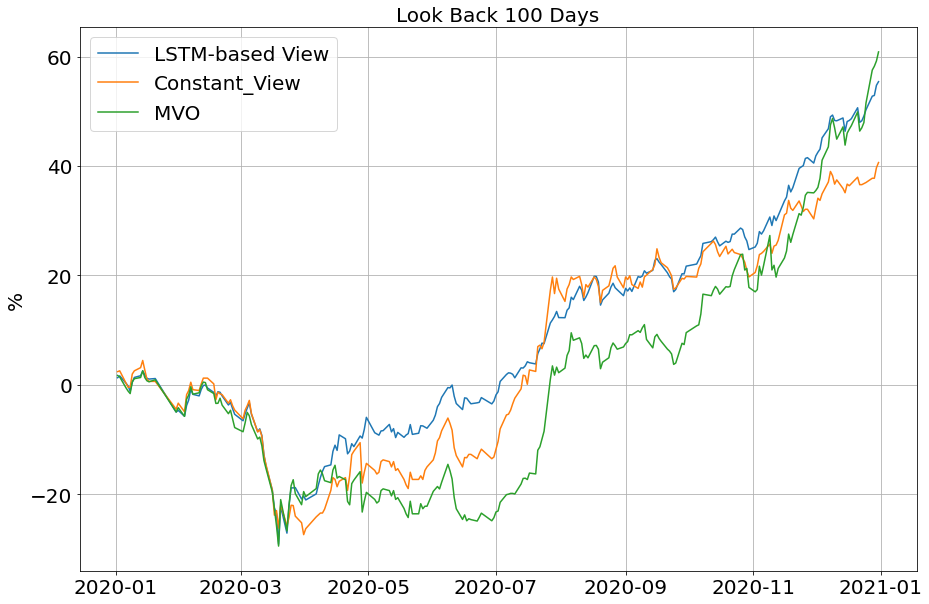

In [21]:
plt.figure(figsize = (15,10))
plt.plot(df_backtest.index,lstm_ret_port[1:],label = 'LSTM-based View')
plt.plot(df_backtest.index,ret_port[1:],label = 'Constant_View')
plt.plot(df_backtest.index,mvo_ret_port[1:],label = 'MVO')
# plt.plot(df_backtest.index,even_ret[1:],label = 'Even Weight')
# plt.plot(df_backtest.index,cw_ret[1:],label = 'Constant Weight')
plt.title('Look Back 100 Days',fontsize = 20)
plt.xticks(fontsize= 20)
plt.yticks(fontsize= 20)
plt.ylabel('%',fontsize = 20)
plt.legend(loc='upper left',fontsize = 20)
plt.grid(True)